In [29]:
import os
from os.path import join
import nibabel as nib
from skimage.measure import label, regionprops
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from scipy.ndimage import zoom


https://www.mathworks.com/help/images/ref/regionprops.html 

In [30]:
def connected_component_analysis(seg, thr=0.5):
    #print(type(seg), seg.shape, seg.min(), seg.max())
    mask = seg.copy()
    mask[mask > thr] = 255
    mask[mask <= thr] = 0

    lbl = label(mask)
    blobs = regionprops(lbl)
    #raw_bbox_list = [b.bbox for b in blobs]
    #axis_major_length_list = [b.axis_major_length for b in blobs]

    return blobs

'''
def cystregionprops(r):
    area = r.area
    major = round(r.axis_major_length, 3)
    
    try:
        minor = round(math.sqrt(10 * (-r.inertia_tensor_eigvals[0] + r.inertia_tensor_eigvals[1] + r.inertia_tensor_eigvals[2])), 3)
    except ValueError:
        minor = np.nan

    return (area, major, minor)
'''


'\ndef cystregionprops(r):\n    area = r.area\n    major = round(r.axis_major_length, 3)\n    \n    try:\n        minor = round(math.sqrt(10 * (-r.inertia_tensor_eigvals[0] + r.inertia_tensor_eigvals[1] + r.inertia_tensor_eigvals[2])), 3)\n    except ValueError:\n        minor = np.nan\n\n    return (area, major, minor)\n'

In [31]:
'''# Folder path
seg_folder_path = '/data/ayc9699/dataset/pancreas_ipmn_ilkin/temporary_folder_cyst_segmentations/nyu/reoriented_renamed'
mri_folder_path = '/data/ayc9699/dataset/pancreas_ipmn_ilkin/nyu/reoriented'

# List to store file paths

mri_file_paths = []
seg_file_paths = []
# Iterate over files in the folder
for root, dirs, files in os.walk(seg_folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        seg_file_paths.append(file_path)

# Print the file paths
for path in seg_file_paths:
    id = path.split("/")[-1].split("_")[1].split(".")[0]
    #print(id)
    mri_file_paths.append(os.path.join(mri_folder_path, f"nyu_{id}.nii.gz"))'''


'# Folder path\nseg_folder_path = \'/data/ayc9699/dataset/pancreas_ipmn_ilkin/temporary_folder_cyst_segmentations/nyu/reoriented_renamed\'\nmri_folder_path = \'/data/ayc9699/dataset/pancreas_ipmn_ilkin/nyu/reoriented\'\n\n# List to store file paths\n\nmri_file_paths = []\nseg_file_paths = []\n# Iterate over files in the folder\nfor root, dirs, files in os.walk(seg_folder_path):\n    for file in files:\n        file_path = os.path.join(root, file)\n        seg_file_paths.append(file_path)\n\n# Print the file paths\nfor path in seg_file_paths:\n    id = path.split("/")[-1].split("_")[1].split(".")[0]\n    #print(id)\n    mri_file_paths.append(os.path.join(mri_folder_path, f"nyu_{id}.nii.gz"))'

In [32]:
'''for i in range(len(seg_file_paths)):
    print(f"pair {i+1}")
    print(seg_file_paths[i-1], "\n", mri_file_paths[i-1])

#print(len(seg_file_paths), len(mri_file_paths))'''

'for i in range(len(seg_file_paths)):\n    print(f"pair {i+1}")\n    print(seg_file_paths[i-1], "\n", mri_file_paths[i-1])\n\n#print(len(seg_file_paths), len(mri_file_paths))'

In [33]:

def create_df():
    column_names=['Center', 'Patient', 'Pancreas_volume_ml', 'Cyst_volume_ml', 'Panc_Cyst_volume_ml', 'Diagonal_mm', 'Panc_vol_to_Diagonal', 'Num_of_Cysts']
    # Add columns using a for loop

    # Define the number of cysts
    num_cysts = 3
    for i in range(num_cysts):
        area_column_name = f'Cyst_{i+1}_vol_ml'
        major_column_name = f'Cyst_{i+1}_major_mm'
        minor_column_name = f'Cyst_{i+1}_minor_mm'
        column_names.append(area_column_name)
        column_names.append(major_column_name)
        column_names.append(minor_column_name)

    # Create an empty DataFrame
    df = pd.DataFrame(columns = column_names)

    df.head()
    return df

In [34]:

def largest3rs(r_list, voxel_sizes):

    voxel_sizes = [voxel_sizes[2], voxel_sizes[1], voxel_sizes[0]]
    sorted_r = sorted(r_list, key=lambda r: r.axis_major_length, reverse=True)
    top_3 = []
    
    for r in sorted_r[:3]:
      
        cov_matrix = r.inertia_tensor

        # Perform eigendecomposition to obtain eigenvectors and eigenvalues
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Determine the dimension along which the major and minor axes lie
        major_axis_dimension = np.argmax(eigenvalues)
        minor_axis_dimension = np.argmin(eigenvalues)

        # Multiply the measurements by the corresponding voxel sizes
        axis_major_length_mm = r.major_axis_length * voxel_sizes[major_axis_dimension]
        try:
            axis_minor_length_mm = r.minor_axis_length * voxel_sizes[minor_axis_dimension]
        except ValueError:
            axis_minor_length_mm = np.nan
        
        # Use the calculated measurements and axis dimensions as needed
        #print(f"Axis Major Length (mm): {axis_major_length_mm}, Dimension: {major_axis_dimension}")
        #print(f"Axis Minor Length (mm): {axis_minor_length_mm}, Dimension: {minor_axis_dimension}")

        vol_ml = r.area * voxel_sizes[0] * voxel_sizes[1] * voxel_sizes[2]/1000

        #major = round(r.axis_major_length, 3)
        
        axis_major_length_mm = round(axis_major_length_mm, 3)
        axis_minor_length_mm = round(axis_minor_length_mm, 3)
        
        '''
        try:
            minor = round(math.sqrt(10 * (-r.inertia_tensor_eigvals[0] + r.inertia_tensor_eigvals[1] + r.inertia_tensor_eigvals[2])), 3)
        except ValueError:
            minor = np.nan
        '''        
        
        top_3.append((vol_ml, axis_major_length_mm, axis_minor_length_mm))
        #top_3.append((vol_ml, major, minor))

    
    return top_3


In [35]:
from skimage.measure import label, regionprops
import numpy as np
def compute_diagonal_length_3D(image, voxel_size_x, voxel_size_y, voxel_size_z):
    # Ensure that image is a binary image
    #print(image.shape)
    assert np.array_equal(image, image.astype(bool)), "Input should be a binary image"

    # Label the image
    labeled_image = label(image)
    #print(np.unique(labeled_image))

    # Compute the properties of the labeled regions
    regions = regionprops(labeled_image)

    # Initialize list to store diagonal lengths
    diagonals = []
    #print("voxel",voxel_size_x, voxel_size_y, voxel_size_z)
    for region in regions:
        # Get the bounding box coordinates
        minp, minr, minc, maxp, maxr, maxc = region.bbox
        # Compute the width, height, and depth of the box
        width = (maxp - minp) * voxel_size_x
        height = (maxr - minr) * voxel_size_y
        depth = (maxc - minc) * voxel_size_z
        #print("debug--------", "depth:", (maxc - minc), "y ekseni:", (maxr - minr),  "x ekseni:", (maxp - minp))
        #print(region.bbox, width, height, depth)

        # Use Pythagorean theorem to compute the diagonal length
        diagonal = np.sqrt(width**2 + height**2 + depth**2)
        diagonals.append(diagonal)

    return diagonals

In [36]:
'''
def largest3rs(r_list):
    sorted_r = sorted(r_list, key=lambda r: r.axis_major_length, reverse=True)
    top_3 = []
    
    for r in sorted_r[:3]:
        area = r.area
        major = round(r.axis_major_length, 3)
        
        try:
            minor = round(math.sqrt(10 * (-r.inertia_tensor_eigvals[0] + r.inertia_tensor_eigvals[1] + r.inertia_tensor_eigvals[2])), 3)
        except ValueError:
            minor = np.nan
        
        top_3.append((area, major, minor))
    
    return top_3
    '''

'\ndef largest3rs(r_list):\n    sorted_r = sorted(r_list, key=lambda r: r.axis_major_length, reverse=True)\n    top_3 = []\n    \n    for r in sorted_r[:3]:\n        area = r.area\n        major = round(r.axis_major_length, 3)\n        \n        try:\n            minor = round(math.sqrt(10 * (-r.inertia_tensor_eigvals[0] + r.inertia_tensor_eigvals[1] + r.inertia_tensor_eigvals[2])), 3)\n        except ValueError:\n            minor = np.nan\n        \n        top_3.append((area, major, minor))\n    \n    return top_3\n    '

In [37]:
def get_volume_ml(label, voxel_vol_mm3):
    volume_mm3 = np.sum(label != 0) * voxel_vol_mm3
    volume_ml = volume_mm3 / 1000
    return volume_ml

In [38]:
'''df = create_df()

for eachpatientind in range(len(seg_file_paths)):
        
    pt_name = seg_file_paths[eachpatientind].split("/")[-1].split("_")[1].split(".")[0]
    if seg_file_paths[eachpatientind].split("/")[-1].split("_")[-1] == 'pass.nii': continue
    if pt_name == '0089': continue

    img_nib = nib.load(mri_file_paths[eachpatientind])
    seg_nib = nib.load(seg_file_paths[eachpatientind])

    if pt_name in ['0140', '0159', '0172']:
        print(seg_file_paths[eachpatientind].split("/")[-1])
        print(pt_name, img_nib.header.get_zooms(), seg_nib.header.get_zooms())
    else:
        assert img_nib.header.get_zooms() == seg_nib.header.get_zooms()
    assert img_nib.shape == seg_nib.shape

    voxel_sizes = img_nib.header.get_zooms()

    img = img_nib.get_fdata()
    seg = seg_nib.get_fdata()

    cysts = (seg == 5)
    pancreas = (seg == 1)
    cysts_b = cysts.astype(int)
    pancreas_b = pancreas.astype(int)
    pancreasandcyst = np.concatenate((cysts_b, pancreas_b))

    # Find Bboxes
    blobs = connected_component_analysis(cysts, thr=0.5)

    # Calculate the voxel volume (assuming isotropic voxel size)
    voxel_vol_mm3 = voxel_sizes[0] *voxel_sizes[1] * voxel_sizes[2]  # Specify the voxel volume in your desired units

    # Calculate the volume of the segmentation mask
    cysts_volume_ml = get_volume_ml(cysts, voxel_vol_mm3)
    pancreas_volume_ml = get_volume_ml(pancreas, voxel_vol_mm3)

    diagonal_lenght = max(compute_diagonal_length_3D(pancreasandcyst, voxel_sizes))
    pancreas_volume_to_diagonal = pancreas_volume_ml / diagonal_lenght

    column_data = ['NYU', pt_name, pancreas_volume_ml, cysts_volume_ml, pancreas_volume_ml + cysts_volume_ml, diagonal_lenght, pancreas_volume_to_diagonal]

    result = largest3rs(blobs, voxel_sizes)
    # Print the result
    for i, props in enumerate(result, start=1):
        #print(f"Top {i}: Area={props[0]}, Major={props[1]}, Minor={props[2]}")
        area, major, minor = props[0], props[1], props[2]
        column_data.append(area)
        column_data.append(major)
        column_data.append(minor)

    column_data.extend([math.nan] * (16 - len(column_data)))
    #print(column_data)

    df.loc[len(df)] = column_data

df.head()

'''

'df = create_df()\n\nfor eachpatientind in range(len(seg_file_paths)):\n        \n    pt_name = seg_file_paths[eachpatientind].split("/")[-1].split("_")[1].split(".")[0]\n    if seg_file_paths[eachpatientind].split("/")[-1].split("_")[-1] == \'pass.nii\': continue\n    if pt_name == \'0089\': continue\n\n    img_nib = nib.load(mri_file_paths[eachpatientind])\n    seg_nib = nib.load(seg_file_paths[eachpatientind])\n\n    if pt_name in [\'0140\', \'0159\', \'0172\']:\n        print(seg_file_paths[eachpatientind].split("/")[-1])\n        print(pt_name, img_nib.header.get_zooms(), seg_nib.header.get_zooms())\n    else:\n        assert img_nib.header.get_zooms() == seg_nib.header.get_zooms()\n    assert img_nib.shape == seg_nib.shape\n\n    voxel_sizes = img_nib.header.get_zooms()\n\n    img = img_nib.get_fdata()\n    seg = seg_nib.get_fdata()\n\n    cysts = (seg == 5)\n    pancreas = (seg == 1)\n    cysts_b = cysts.astype(int)\n    pancreas_b = pancreas.astype(int)\n    pancreasandcyst = n

In [39]:
'''# Save the DataFrame to a CSV file
df.to_csv('server_cyst_segmentation_nyu.csv', index=False)
print(df['Center'].value_counts())'''

"# Save the DataFrame to a CSV file\ndf.to_csv('server_cyst_segmentation_nyu.csv', index=False)\nprint(df['Center'].value_counts())"

In [40]:
nyu_df = pd.read_csv('server_cyst_segmentation_nyu.csv')
allegheny_df = pd.read_csv('server_cyst_segmentation_allegheny.csv')
mayo_arizona_df = pd.read_csv('server_cyst_segmentation_mayo_arizona.csv')
northwestern_df = pd.read_csv('server_cyst_segmentation_northwestern.csv')
mayo_florida_cad_df = pd.read_csv('server_cyst_segmentation_mayo_florida_cad.csv')
mayo_florida_mcf_df = pd.read_csv('server_cyst_segmentation_mayo_florida_mcf.csv')

all_df = pd.concat([nyu_df, allegheny_df, mayo_arizona_df, northwestern_df, mayo_florida_cad_df, mayo_florida_mcf_df])
all_df['Center'] = all_df['Center'].replace('Allegenhy', 'Allegheny')
all_df['Patient'] = all_df['Patient'].astype('int')
print(all_df.dtypes)
print(all_df['Center'].value_counts())
all_df


Center                   object
Patient                   int64
Pancreas_volume_ml      float64
Cyst_volume_ml          float64
Panc_Cyst_volume_ml     float64
Diagonal_mm             float64
Panc_vol_to_Diagonal    float64
Num_of_Cysts              int64
Cyst_1_vol_ml           float64
Cyst_1_major_mm         float64
Cyst_1_minor_mm         float64
Cyst_2_vol_ml           float64
Cyst_2_major_mm         float64
Cyst_2_minor_mm         float64
Cyst_3_vol_ml           float64
Cyst_3_major_mm         float64
Cyst_3_minor_mm         float64
dtype: object
NYU                 79
Mayo Florida CAD    54
Allegheny           21
Mayo Arizona        20
Northwestern        20
Mayo Florida MCF    20
Name: Center, dtype: int64


,Center,Patient,Pancreas_volume_ml,Cyst_volume_ml,Panc_Cyst_volume_ml,Diagonal_mm,Panc_vol_to_Diagonal,Num_of_Cysts,Cyst_1_vol_ml,Cyst_1_major_mm,Cyst_1_minor_mm,Cyst_2_vol_ml,Cyst_2_major_mm,Cyst_2_minor_mm,Cyst_3_vol_ml,Cyst_3_major_mm,Cyst_3_minor_mm
0,NYU,20,97.764258,13.383984,111.148242,208.048466,0.469911,10,12.498047,33.445,3.161600e+01,0.137109,12.912,0.000000e+00,0.290039,9.963,NaN
1,NYU,168,64.943360,30.059498,95.002857,199.563628,0.325427,9,28.809459,56.277,4.319200e+01,0.400403,15.445,NaN,0.097659,10.825,0.000000e+00
2,NYU,133,71.207464,0.997658,72.205123,187.254020,0.380272,1,0.997658,15.389,9.648000e+00,NaN,NaN,NaN,NaN,NaN,NaN
3,NYU,118,31.687012,8.073730,39.760742,170.979488,0.185326,33,2.832031,105.630,2.637200e+01,4.428711,44.700,3.541600e+01,0.063477,8.588,4.383000e+00
4,NYU,99,45.633945,0.156013,45.789959,160.418620,0.284468,19,0.028366,4.917,0.000000e+00,0.007092,0.000,0.000000e+00,0.007092,0.000,0.000000e+00
5,NYU,173,53.115234,0.878906,53.994141,180.875864,0.293656,13,0.146484,9.789,8.297000e+00,0.097656,9.494,4.164000e+00,0.097656,8.803,4.490000e+00
6,NYU,26,20.577667,0.131592,20.709259,134.433614,0.153069,4,0.032898,3.057,0.000000e+00,0.032898,3.057,0.000000e+00,0.032898,3.057,0.000000e+00
7,NYU,63,36.154248,1.959521,38.113770,134.653730,0.268498,1,1.959521,17.672,1.336700e+01,NaN,NaN,NaN,NaN,NaN,NaN
8,NYU,47,49.586105,2.634144,52.220249,159.137873,0.311592,30,0.557041,18.831,1.700700e+01,0.151062,14.073,5.733000e+00,0.311565,11.845,1.003400e+01
9,NYU,127,35.357952,16.824532,52.182484,173.565303,0.203716,9,14.407540,61.921,3.311300e+01,0.557041,19.303,8.661000e+00,0.358772,17.079,0.000000e+00


In [41]:
duct_info_df = pd.read_csv('duct_measurements_all.csv')

# Create a mask where 'center' is 'NYU'
mask = duct_info_df['Center'] == 'NYU'
# Apply the changes only where the mask is True
duct_info_df.loc[mask, 'Patient'] = duct_info_df.loc[mask, 'Patient'].str.replace('patient_', '')  # remove 'patient_'
duct_info_df.loc[mask, 'Patient'] = duct_info_df.loc[mask, 'Patient'].str.replace('.nii', '')  # remove '.nii'

# Create a mask where 'center' is 'Allegenhy'
mask = duct_info_df['Center'] == 'Allegheny'
# Apply the changes only where the mask is True
duct_info_df.loc[mask, 'Patient'] = duct_info_df.loc[mask, 'Patient'].str.replace('ahn', '') 
duct_info_df.loc[mask, 'Patient'] = duct_info_df.loc[mask, 'Patient'].str.replace('Ahn', '') 

# Create a mask where 'center' is 'Mayo Arizona'
mask = duct_info_df['Center'] == 'Mayo Arizona'
# Apply the changes only where the mask is True
duct_info_df.loc[mask, 'Patient'] = duct_info_df.loc[mask, 'Patient'].str.replace('mca', '') 
duct_info_df.loc[mask, 'Patient'] = duct_info_df.loc[mask, 'Patient'].str.replace('Mca', '') 


# Create a mask where 'center' is 'Northwestern'
mask = duct_info_df['Center'] == 'Northwestern'
# Apply the changes only where the mask is True
duct_info_df.loc[mask, 'Patient'] = duct_info_df.loc[mask, 'Patient'].str.replace('NM', '') 

# Create a mask where 'center' is 'Mayo Florida MCF'
mask = duct_info_df['Center'] == 'Mayo Florida MCF'
# Apply the changes only where the mask is True
duct_info_df.loc[mask, 'Patient'] = duct_info_df.loc[mask, 'Patient'].str.replace('mcf', '') 

# Create a mask where 'center' is 'Mayo Florida CAD'
mask = duct_info_df['Center'] == 'Mayo Florida CDA'
# Apply the changes only where the mask is True
duct_info_df.loc[mask, 'Center'] = duct_info_df.loc[mask, 'Center'].str.replace('CDA', 'CAD') 
duct_info_df.loc[mask, 'Patient'] = duct_info_df.loc[mask, 'Patient'].str.replace('cad', '') 
duct_info_df.loc[mask, 'Patient'] = duct_info_df.loc[mask, 'Patient'].str.replace('Cad', '') 
duct_info_df.loc[mask, 'Patient'] = duct_info_df.loc[mask, 'Patient'].str.replace('mayo clinic', '') 

duct_info_df = duct_info_df.rename(columns={'Maximum diameter (mm)': 'Duct_max_mm', 'Location of maximum': 'Loc_max',
                        'Minimum diameter (mm)': 'Duct_min_mm', 'Location of minimum': 'Loc_min'})

# Create a dictionary mapping current values to new values
replacement_dict = {'head': 1, 'neck': 1, 'tail': 2, 'body': 3, 'Body': 3, 'body/tail': 3}

# Replace the values
duct_info_df['Loc_max'] = duct_info_df['Loc_max'].replace(replacement_dict)
duct_info_df['Loc_min'] = duct_info_df['Loc_min'].replace(replacement_dict)

pd.set_option('display.max_rows', 20)
duct_info_df['Patient'] = duct_info_df['Patient'].astype('int')

#duct_info_df['Center'] = duct_info_df['Center'].replace('Allegheny', 'AHN')

print(duct_info_df.dtypes)
print(duct_info_df['Center'].value_counts())

pd.set_option('display.max_rows', None)
duct_info_df

Center          object
Patient          int64
Duct_max_mm    float64
Loc_max          int64
Duct_min_mm    float64
Loc_min        float64
dtype: object
NYU                 78
Mayo Florida CAD    55
Allegheny           27
Mayo Arizona        25
Mayo Florida MCF    24
Northwestern        20
Name: Center, dtype: int64


/tmp/ipykernel_162586/3984908663.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  duct_info_df.loc[mask, 'Patient'] = duct_info_df.loc[mask, 'Patient'].str.replace('.nii', '')  # remove '.nii'


,Center,Patient,Duct_max_mm,Loc_max,Duct_min_mm,Loc_min
0,Allegheny,5,4.290,2,1.520,3.0
1,Allegheny,58,2.444,1,1.655,3.0
2,Allegheny,11,2.287,3,9.875,NaN
3,Allegheny,12,11.260,3,2.324,3.0
4,Allegheny,16,1.594,3,1.199,3.0
5,Allegheny,19,3.850,1,1.254,2.0
6,Allegheny,2,3.695,1,2.659,3.0
7,Allegheny,21,3.070,2,2.579,1.0
8,Allegheny,23,2.707,1,2.238,2.0
9,Allegheny,27,3.018,1,2.821,2.0


In [42]:
df1 = all_df
df2 = duct_info_df

merged_df = pd.merge(df1, df2, on=['Center', 'Patient'], how='outer', indicator=True)

# Rows in both dataframes
in_both = merged_df[merged_df['_merge'] == 'both']

# Rows only in df1
only_in_df1 = merged_df[merged_df['_merge'] == 'left_only']

# Rows only in df2
only_in_df2 = merged_df[merged_df['_merge'] == 'right_only']

print(f'Number of rows in both dataframes: {len(in_both)}')
print(f'Number of rows only in df1: {len(only_in_df1)}')
print(f'Number of rows only in df2: {len(only_in_df2)}')

print('Rows only in df1:')
print(only_in_df1[['Center', 'Patient']])

print('Rows only in df2:')
pd.set_option('display.max_rows', None)
only_in_df2.to_csv('missing_segmentations.csv', index=False)
print(only_in_df2['Center'].value_counts())
only_in_df2

Number of rows in both dataframes: 214
Number of rows only in df1: 0
Number of rows only in df2: 16
Rows only in df1:
Empty DataFrame
Columns: [Center, Patient]
Index: []
Rows only in df2:


Allegheny           6
Mayo Arizona        5
Mayo Florida MCF    4
Mayo Florida CAD    1
Name: Center, dtype: int64


,Center,Patient,Pancreas_volume_ml,Cyst_volume_ml,Panc_Cyst_volume_ml,Diagonal_mm,Panc_vol_to_Diagonal,Num_of_Cysts,Cyst_1_vol_ml,Cyst_1_major_mm,Cyst_1_minor_mm,Cyst_2_vol_ml,Cyst_2_major_mm,Cyst_2_minor_mm,Cyst_3_vol_ml,Cyst_3_major_mm,Cyst_3_minor_mm,Duct_max_mm,Loc_max,Duct_min_mm,Loc_min,_merge
214,Allegheny,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.104,1,1.839,2.0,right_only
215,Allegheny,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.459,1,1.747,2.0,right_only
216,Allegheny,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.902,2,1.400,2.0,right_only
217,Allegheny,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.403,3,2.245,3.0,right_only
218,Allegheny,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.010,1,2.362,2.0,right_only
219,Allegheny,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.229,1,1.685,2.0,right_only
220,Mayo Florida CAD,163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.467,3,1.803,3.0,right_only
221,Mayo Arizona,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.637,3,2.063,2.0,right_only
222,Mayo Arizona,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.375,1,1.289,3.0,right_only
223,Mayo Arizona,138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.576,3,1.549,2.0,right_only


In [43]:
merged_df

,Center,Patient,Pancreas_volume_ml,Cyst_volume_ml,Panc_Cyst_volume_ml,Diagonal_mm,Panc_vol_to_Diagonal,Num_of_Cysts,Cyst_1_vol_ml,Cyst_1_major_mm,Cyst_1_minor_mm,Cyst_2_vol_ml,Cyst_2_major_mm,Cyst_2_minor_mm,Cyst_3_vol_ml,Cyst_3_major_mm,Cyst_3_minor_mm,Duct_max_mm,Loc_max,Duct_min_mm,Loc_min,_merge
0,NYU,20,97.764258,13.383984,111.148242,208.048466,0.469911,10.0,12.498047,33.445,3.161600e+01,0.137109,12.912,0.000000e+00,0.290039,9.963,NaN,2.117,3,1.090,3.0,both
1,NYU,168,64.943360,30.059498,95.002857,199.563628,0.325427,9.0,28.809459,56.277,4.319200e+01,0.400403,15.445,NaN,0.097659,10.825,0.000000e+00,3.717,3,2.535,2.0,both
2,NYU,133,71.207464,0.997658,72.205123,187.254020,0.380272,1.0,0.997658,15.389,9.648000e+00,NaN,NaN,NaN,NaN,NaN,NaN,3.022,1,1.904,3.0,both
3,NYU,118,31.687012,8.073730,39.760742,170.979488,0.185326,33.0,2.832031,105.630,2.637200e+01,4.428711,44.700,3.541600e+01,0.063477,8.588,4.383000e+00,7.187,1,2.334,2.0,both
4,NYU,99,45.633945,0.156013,45.789959,160.418620,0.284468,19.0,0.028366,4.917,0.000000e+00,0.007092,0.000,0.000000e+00,0.007092,0.000,0.000000e+00,2.029,3,1.309,2.0,both
5,NYU,173,53.115234,0.878906,53.994141,180.875864,0.293656,13.0,0.146484,9.789,8.297000e+00,0.097656,9.494,4.164000e+00,0.097656,8.803,4.490000e+00,2.620,1,1.690,2.0,both
6,NYU,26,20.577667,0.131592,20.709259,134.433614,0.153069,4.0,0.032898,3.057,0.000000e+00,0.032898,3.057,0.000000e+00,0.032898,3.057,0.000000e+00,2.354,1,1.788,3.0,both
7,NYU,63,36.154248,1.959521,38.113770,134.653730,0.268498,1.0,1.959521,17.672,1.336700e+01,NaN,NaN,NaN,NaN,NaN,NaN,1.708,1,1.559,2.0,both
8,NYU,47,49.586105,2.634144,52.220249,159.137873,0.311592,30.0,0.557041,18.831,1.700700e+01,0.151062,14.073,5.733000e+00,0.311565,11.845,1.003400e+01,3.085,3,2.789,3.0,both
9,NYU,127,35.357952,16.824532,52.182484,173.565303,0.203716,9.0,14.407540,61.921,3.311300e+01,0.557041,19.303,8.661000e+00,0.358772,17.079,0.000000e+00,2.815,1,1.681,1.0,both


In [44]:
#allegheny
northwestern_path = '/data/ayc9699/dataset/pancreas_ipmn_ilkin/allegheny/t2/gt_segmentation_t2/reoriented'
northwestern_patients_list = []
# Iterate through the DataFrame rows
for index, row in only_in_df2.iterrows():
    # Check if the 'center' column value is equal to 'AHN'
    if row['Center'] == 'Northwestern':
        # If it matches, append the 'patient' column value to the list
        northwestern_patients_list.append(int(row['Patient']))
#

# Initialize an empty list to store matching patient IDs
northwestern_matching_patients = []

# Iterate through all files in the directory
for filename in os.listdir(northwestern_path):
    if filename.endswith('.nii.gz'):
        # Extract the patient ID from the filename
        patient_id = int(filename.split('_')[1].split('.')[0])
        # Check if the patient ID is in the patients_list
        if patient_id in northwestern_patients_list:
            northwestern_matching_patients.append(f'northwerstern_{patient_id}.nii.gz') #?

print('Northwestern')
print(northwestern_patients_list)
print(northwestern_matching_patients)

#allegheny
allegheny_path = '/data/ayc9699/dataset/pancreas_ipmn_ilkin/allegheny/t2/gt_segmentation_t2/reoriented'
allegheny_patients_list = []
# Iterate through the DataFrame rows
for index, row in only_in_df2.iterrows():
    # Check if the 'center' column value is equal to 'AHN'
    if row['Center'] == 'AHN':
        # If it matches, append the 'patient' column value to the list
        allegheny_patients_list.append(int(row['Patient']))
#

# Initialize an empty list to store matching patient IDs
allegheny_matching_patients = []

# Iterate through all files in the directory
for filename in os.listdir(allegheny_path):
    if filename.endswith('.nii.gz'):
        # Extract the patient ID from the filename
        patient_id = int(filename.split('_')[1].split('.')[0])
        # Check if the patient ID is in the patients_list
        if patient_id in allegheny_patients_list:
            allegheny_matching_patients.append(f'ahn_{patient_id}.nii.gz') #?

print('AHN')
print(allegheny_patients_list)
print(allegheny_matching_patients)

#mayo_arizona
mayo_arizona_path = '/data/ayc9699/dataset/pancreas_ipmn_ilkin/mayo_arizona/t2/gt_segmentation_t2/reoriented'
mayo_arizona_patients_list = []
# Iterate through the DataFrame rows
for index, row in only_in_df2.iterrows():
    # Check if the 'center' column value is equal to 'AHN'
    if row['Center'] == 'Mayo Arizona':
        # If it matches, append the 'patient' column value to the list
        mayo_arizona_patients_list.append(int(row['Patient']))
#

# Initialize an empty list to store matching patient IDs
mayo_arizona_matching_patients = []

# Iterate through all files in the directory
for filename in os.listdir(mayo_arizona_path):
    if filename.endswith('.nii.gz'):
        # Extract the patient ID from the filename
        patient_id = int(filename.split('_')[1].split('.')[0])
        # Check if the patient ID is in the patients_list
        if patient_id in mayo_arizona_patients_list:
            mayo_arizona_matching_patients.append(patient_id)

print('Mayo Arizona')
print(mayo_arizona_patients_list)
print(mayo_arizona_matching_patients)

#nyu
nyu_path = '/data/ayc9699/dataset/pancreas_ipmn_ilkin/nyu/t2/gt_segmentation_t2/reoriented'
nyu_patients_list = []
# Iterate through the DataFrame rows
for index, row in only_in_df2.iterrows():
    # Check if the 'center' column value is equal to 'AHN'
    if row['Center'] == 'NYU':
        # If it matches, append the 'patient' column value to the list
        nyu_patients_list.append(int(row['Patient']))
#

# Initialize an empty list to store matching patient IDs
nyu_matching_patients = []

# Iterate through all files in the directory
for filename in os.listdir(nyu_path):
    if filename.endswith('.nii.gz'):
        # Extract the patient ID from the filename
        patient_id = int(filename.split('_')[1].split('.')[0])
        # Check if the patient ID is in the patients_list
        if patient_id in nyu_patients_list:
            nyu_matching_patients.append(patient_id)

print("NYU")
print(nyu_patients_list)
print(nyu_matching_patients)

Northwestern
[]
[]
AHN
[]
[]
Mayo Arizona
[5, 10, 138, 24, 30]
[]
NYU
[]
[]


In [45]:
def missing_rows_df(path_dir, matching_patients, center, ):
    missing_df = create_df()

    for eachpatientind in range(len(matching_patients)):
        pt_name = matching_patients[eachpatientind]
        print(pt_name)
        if center == 'Allegheny':
            image_name = f'ahn_{pt_name}.nii.gz'
        if center == 'Mayo Arizona':
            image_name = f'mca_{pt_name}.nii.gz'
        if center == 'NYU':
            image_name = f'nyu_{str(pt_name).zfill(4)}.nii.gz'
        

        path = os.path.join(path_dir, image_name)
        print(path)

        seg_nib = nib.load(path)

        voxel_sizes = seg_nib.header.get_zooms()
        if voxel_sizes[2]>30:
            voxel_sizes = tuple(size / 1000 for size in voxel_sizes)
        seg = seg_nib.get_fdata()

        cysts = (seg == 5)
        pancreas = (seg == 1)
        cysts_b = cysts.astype(int)
        pancreas_b = pancreas.astype(int)
        pancreasandcyst = np.concatenate((cysts_b, pancreas_b))

        # Find Bboxes
        blobs = connected_component_analysis(cysts, thr=0.5)
        num_of_cysts = len(blobs)

        # Calculate the voxel volume (assuming isotropic voxel size)
        voxel_vol_mm3 = voxel_sizes[0] *voxel_sizes[1] * voxel_sizes[2]  # Specify the voxel volume in your desired units

        # Calculate the volume of the segmentation mask
        cysts_volume_ml = get_volume_ml(cysts, voxel_vol_mm3)
        pancreas_volume_ml = get_volume_ml(pancreas, voxel_vol_mm3)

        diagonal_lenght = max(compute_diagonal_length_3D(pancreasandcyst, voxel_sizes[0], voxel_sizes[1], voxel_sizes[2]))
        pancreas_volume_to_diagonal = pancreas_volume_ml / diagonal_lenght

        column_data = [center, pt_name, pancreas_volume_ml, cysts_volume_ml, pancreas_volume_ml + cysts_volume_ml, diagonal_lenght, num_of_cysts]

        result = largest3rs(blobs, voxel_sizes)
        # Print the result
        for i, props in enumerate(result, start=1):
            #print(f"Top {i}: Area={props[0]}, Major={props[1]}, Minor={props[2]}")
            area, major, minor = props[0], props[1], props[2]
            column_data.append(area)
            column_data.append(major)
            column_data.append(minor)

        column_data.extend([math.nan] * (17 - len(column_data)))
        #print(column_data)

        missing_df.loc[len(missing_df)] = column_data

    return missing_df

In [46]:
allegheny_missing_df = missing_rows_df(allegheny_path, allegheny_matching_patients, 'Allegheny')
mayo_arizona_missing_df = missing_rows_df(mayo_arizona_path, mayo_arizona_matching_patients, 'Mayo Arizona')
nyu_missing_df = missing_rows_df(nyu_path, nyu_matching_patients, 'NYU')
all__with_missing_df = pd.concat([allegheny_missing_df, mayo_arizona_missing_df, nyu_missing_df])
all__with_missing_df

,Center,Patient,Pancreas_volume_ml,Cyst_volume_ml,Panc_Cyst_volume_ml,Diagonal_mm,Panc_vol_to_Diagonal,Num_of_Cysts,Cyst_1_vol_ml,Cyst_1_major_mm,Cyst_1_minor_mm,Cyst_2_vol_ml,Cyst_2_major_mm,Cyst_2_minor_mm,Cyst_3_vol_ml,Cyst_3_major_mm,Cyst_3_minor_mm


In [47]:
df1_2 = all__with_missing_df
df2_2 = duct_info_df

merged_df_2 = pd.merge(df1_2, df2_2, on=['Center', 'Patient'], how='outer', indicator=True)

# Rows in both dataframes
in_both_2 = merged_df_2[merged_df_2['_merge'] == 'both']

# Rows only in df1
only_in_df1_2 = merged_df_2[merged_df_2['_merge'] == 'left_only']

# Rows only in df2
only_in_df2_2 = merged_df_2[merged_df_2['_merge'] == 'right_only']

print(f'Number of rows in both dataframes: {len(in_both_2)}')
print(f'Number of rows only in df1: {len(only_in_df1_2)}')
print(f'Number of rows only in df2: {len(only_in_df2_2)}')

print('Rows only in df1:')
print(only_in_df1_2[['Center', 'Patient']])

print('Rows only in df2:')
pd.set_option('display.max_rows', None)
print(only_in_df2_2['Center'].value_counts())
in_both_2

Number of rows in both dataframes: 0
Number of rows only in df1: 0
Number of rows only in df2: 229
Rows only in df1:
Empty DataFrame
Columns: [Center, Patient]
Index: []
Rows only in df2:
NYU                 78
Mayo Florida CAD    55
Allegheny           27
Mayo Arizona        25
Mayo Florida MCF    24
Northwestern        20
Name: Center, dtype: int64


,Pancreas_volume_ml,Cyst_volume_ml,Panc_Cyst_volume_ml,Diagonal_mm,Panc_vol_to_Diagonal,Num_of_Cysts,Cyst_1_vol_ml,Cyst_1_major_mm,Cyst_1_minor_mm,Cyst_2_vol_ml,Cyst_2_major_mm,Cyst_2_minor_mm,Cyst_3_vol_ml,Cyst_3_major_mm,Cyst_3_minor_mm,Center,Patient,Duct_max_mm,Loc_max,Duct_min_mm,Loc_min,_merge


In [48]:
gt_seg_added_with_duct_df = pd.concat([in_both, in_both_2])
gt_seg_added_with_duct_df

,Center,Patient,Pancreas_volume_ml,Cyst_volume_ml,Panc_Cyst_volume_ml,Diagonal_mm,Panc_vol_to_Diagonal,Num_of_Cysts,Cyst_1_vol_ml,Cyst_1_major_mm,Cyst_1_minor_mm,Cyst_2_vol_ml,Cyst_2_major_mm,Cyst_2_minor_mm,Cyst_3_vol_ml,Cyst_3_major_mm,Cyst_3_minor_mm,Duct_max_mm,Loc_max,Duct_min_mm,Loc_min,_merge
0,NYU,20,97.764258,13.383984,111.148242,208.048466,0.469911,10.0,12.498047,33.445,3.161600e+01,0.137109,12.912,0.000000e+00,0.290039,9.963,NaN,2.117,3,1.090,3.0,both
1,NYU,168,64.943360,30.059498,95.002857,199.563628,0.325427,9.0,28.809459,56.277,4.319200e+01,0.400403,15.445,NaN,0.097659,10.825,0.000000e+00,3.717,3,2.535,2.0,both
2,NYU,133,71.207464,0.997658,72.205123,187.254020,0.380272,1.0,0.997658,15.389,9.648000e+00,NaN,NaN,NaN,NaN,NaN,NaN,3.022,1,1.904,3.0,both
3,NYU,118,31.687012,8.073730,39.760742,170.979488,0.185326,33.0,2.832031,105.630,2.637200e+01,4.428711,44.700,3.541600e+01,0.063477,8.588,4.383000e+00,7.187,1,2.334,2.0,both
4,NYU,99,45.633945,0.156013,45.789959,160.418620,0.284468,19.0,0.028366,4.917,0.000000e+00,0.007092,0.000,0.000000e+00,0.007092,0.000,0.000000e+00,2.029,3,1.309,2.0,both
5,NYU,173,53.115234,0.878906,53.994141,180.875864,0.293656,13.0,0.146484,9.789,8.297000e+00,0.097656,9.494,4.164000e+00,0.097656,8.803,4.490000e+00,2.620,1,1.690,2.0,both
6,NYU,26,20.577667,0.131592,20.709259,134.433614,0.153069,4.0,0.032898,3.057,0.000000e+00,0.032898,3.057,0.000000e+00,0.032898,3.057,0.000000e+00,2.354,1,1.788,3.0,both
7,NYU,63,36.154248,1.959521,38.113770,134.653730,0.268498,1.0,1.959521,17.672,1.336700e+01,NaN,NaN,NaN,NaN,NaN,NaN,1.708,1,1.559,2.0,both
8,NYU,47,49.586105,2.634144,52.220249,159.137873,0.311592,30.0,0.557041,18.831,1.700700e+01,0.151062,14.073,5.733000e+00,0.311565,11.845,1.003400e+01,3.085,3,2.789,3.0,both
9,NYU,127,35.357952,16.824532,52.182484,173.565303,0.203716,9.0,14.407540,61.921,3.311300e+01,0.557041,19.303,8.661000e+00,0.358772,17.079,0.000000e+00,2.815,1,1.681,1.0,both


In [49]:
add_mayo_arizona_df = pd.read_csv('/data/ayc9699/repo/pancreas/CystXPancreaticCysts-MayoArizona_DATA_2022-07-13_1118 v2.csv')
add_mayo_arizona_df['Patient'] = add_mayo_arizona_df['record_id'].str.replace('MCA', '')
add_mayo_arizona_df['Center'] = 'Mayo Arizona'
add_mayo_arizona_df = add_mayo_arizona_df[['Center','Patient','dob', 'birth_sex', 'alive', 'cyto_path', 'cyst_location', 'surgery', 'surg_path']].copy()
add_mayo_arizona_df = add_mayo_arizona_df.dropna(subset=['Center','Patient','dob', 'birth_sex', 'alive', 'cyto_path', 'cyst_location', 'surgery', 'surg_path'], thresh=4)
add_mayo_arizona_df['Patient'] = add_mayo_arizona_df['Patient'].apply(pd.to_numeric, errors='coerce', downcast='integer')
#print(add_mayo_arizona_df.dtypes)

#mayo_arizona_labels_df = pd.read_csv('/data/ayc9699/repo/pancreas/MCA with Label.csv')
mayo_arizona_labels_df = pd.read_csv('/data/ayc9699/repo/pancreas/MCA_label.csv')
mayo_arizona_labels_df['Number'] = mayo_arizona_labels_df['Number'].str.replace('MCA', '').astype(int)
mayo_arizona_labels_df = mayo_arizona_labels_df.drop('Unnamed: 3', axis=1)
mayo_arizona_labels_df = mayo_arizona_labels_df.drop('Path', axis=1)
mayo_arizona_labels_df = mayo_arizona_labels_df.rename(columns={'Label': 'label'})

merged_mca_df = add_mayo_arizona_df.merge(mayo_arizona_labels_df, left_on='Patient', right_on='Number')
merged_mca_df = merged_mca_df.drop('Number', axis=1)
merged_mca_df.head()

,Center,Patient,dob,birth_sex,alive,cyto_path,cyst_location,surgery,surg_path,label
0,Mayo Arizona,2.0,10/1/41,1.0,1.0,1.0,2.0,1.0,1.0,1.0
1,Mayo Arizona,5.0,9/1/48,0.0,1.0,0.0,0.0,1.0,1.0,1.0
2,Mayo Arizona,10.0,3/1/52,1.0,1.0,0.0,1.0,1.0,3.0,3.0
3,Mayo Arizona,11.0,12/1/63,0.0,1.0,0.0,8.0,1.0,2.0,2.0
4,Mayo Arizona,12.0,3/1/39,1.0,1.0,1.0,0.0,1.0,8.0,NaN


In [50]:
mayo_florida_cad_labels_df = pd.read_csv('/data/ayc9699/repo/pancreas/mayo_clinic_florida_v1.csv')
mayo_florida_cad_labels_df['Patient'] = mayo_florida_cad_labels_df['ipmn_label'].str.replace('CAD-', '').astype(int)
mayo_florida_cad_labels_df = mayo_florida_cad_labels_df.drop('ipmn_label', axis=1)
mayo_florida_cad_labels_df = mayo_florida_cad_labels_df.rename(columns={'Unnamed: 1': 'label'})
mayo_florida_cad_labels_df['Center'] = 'Mayo Florida CAD'

merged_cad_df = mayo_florida_cad_labels_df
merged_cad_df.head()

,label,Patient,Center
0,0,1,Mayo Florida CAD
1,0,3,Mayo Florida CAD
2,0,5,Mayo Florida CAD
3,0,9,Mayo Florida CAD
4,0,11,Mayo Florida CAD


In [51]:
add_mayo_florida_mcf_df = pd.read_csv('/data/ayc9699/repo/pancreas/CystXPancreaticCysts-MayoFlorida excel_DATA_2022-07-13_1118 v2.csv')
add_mayo_florida_mcf_df['Patient'] = add_mayo_florida_mcf_df['record_id'].str.replace('MCF', '')
add_mayo_florida_mcf_df['Center'] = 'Mayo Florida MCF'
add_mayo_florida_mcf_df = add_mayo_florida_mcf_df[['Center','Patient','dob', 'birth_sex', 'alive', 'cyto_path', 'cyst_location', 'surgery', 'surg_path']].copy()
add_mayo_florida_mcf_df = add_mayo_florida_mcf_df.dropna(subset=['Center','Patient','dob', 'birth_sex', 'alive', 'cyto_path', 'cyst_location', 'surgery', 'surg_path'], thresh=4)
add_mayo_florida_mcf_df['Patient'] = add_mayo_florida_mcf_df['Patient'].apply(pd.to_numeric, errors='coerce', downcast='integer')

#add_mayo_florida_mcf_labels_df = pd.read_csv('/data/ayc9699/repo/pancreas/MCF.csv')
add_mayo_florida_mcf_labels_df = pd.read_csv('/data/ayc9699/repo/pancreas/MCF_label.csv')
add_mayo_florida_mcf_labels_df['Patient'] = add_mayo_florida_mcf_labels_df['Patient'].str.replace('MCF', '').astype(int)
add_mayo_florida_mcf_labels_df = add_mayo_florida_mcf_labels_df.drop('Unnamed: 2', axis=1)
add_mayo_florida_mcf_labels_df = add_mayo_florida_mcf_labels_df.rename(columns={'Label': 'label'})

merged_mcf_df = add_mayo_florida_mcf_df.merge(add_mayo_florida_mcf_labels_df, left_on='Patient', right_on='Patient')
merged_mcf_df.head()


,Center,Patient,dob,birth_sex,alive,cyto_path,cyst_location,surgery,surg_path,label
0,Mayo Florida MCF,3,5/1/48,1.0,1.0,1.0,2.0,1.0,1.0,1
1,Mayo Florida MCF,4,4/1/45,0.0,1.0,0.0,2.0,1.0,1.0,1
2,Mayo Florida MCF,5,9/1/42,0.0,1.0,1.0,0.0,1.0,3.0,3
3,Mayo Florida MCF,6,7/1/59,0.0,1.0,1.0,1.0,1.0,2.0,2
4,Mayo Florida MCF,10,6/1/39,1.0,8.0,0.0,NaN,1.0,1.0,1


In [52]:
add_nyu_df = pd.read_csv('/data/ayc9699/repo/pancreas/Demographic Data_IDs_NYU.csv')
add_nyu_df['Patient'] = add_nyu_df['record_id']
add_nyu_df['Center'] = 'NYU'
add_nyu_df = add_nyu_df[['Center','Patient','dob', 'birth_sex', 'alive', 'cyto_path', 'cyst_location', 'surgery', 'surg_path']].copy()
#add_nyu_df['Patient'] = add_nyu_df['Patient'].apply(pd.to_numeric, errors='coerce', downcast='integer')
#print(add_nyu_df.dtypes)
add_nyu_df.head()
nyu_full_df = pd.read_csv('/data/ayc9699/repo/pancreas/NYU_pancreas_segmentation_FullVersion.csv')
nyu_full_df = nyu_full_df[['Patient#','Case#','label']].copy()
nyu_full_df['Patient#'] = nyu_full_df['Patient#'].apply(lambda x: int(x.split('_')[-1].lstrip('0')) if isinstance(x, str) else x)
print(nyu_full_df.dtypes)
nyu_full_df.head()
merged_nyu_df = add_nyu_df.merge(nyu_full_df, left_on='Patient', right_on='Case#', suffixes=('_add_nyu', '_nyu_full'))
merged_nyu_df = merged_nyu_df.drop('Patient', axis=1)
merged_nyu_df = merged_nyu_df.drop('Case#', axis=1)
merged_nyu_df = merged_nyu_df.rename(columns={'Patient#': 'Patient'})
merged_nyu_df.head()

Patient#    float64
Case#        object
label       float64
dtype: object


,Center,dob,birth_sex,alive,cyto_path,cyst_location,surgery,surg_path,Patient,label
0,NYU,2/4/54,0,1,0.0,0.0,1.0,2,73.0,2.0
1,NYU,12/22/67,1,1,0.0,2.0,1.0,MCN HGD,NaN,2.0
2,NYU,7/8/55,0,1,0.0,2.0,1.0,2,NaN,2.0
3,NYU,11/19/47,0,1,0.0,8.0,1.0,2,NaN,2.0
4,NYU,12/26/58,0,1,0.0,0.0,1.0,2,171.0,2.0


In [53]:
add_allegheny_df = pd.read_csv('/data/ayc9699/repo/pancreas/Excel sheet AHN_ME.csv')
#surgery -> If surgery, date of Arrival tissue: dd/mm/yyyy 9=not applicable


add_allegheny_df = add_allegheny_df.rename(columns={'If surgery, date of Arrival tissue: dd/mm/yyyy 9=not applicable': 'surgery', 
                                                    'Alive\n0=dead, 1=alive, \n8= not described, 9=not applicable': 'alive', 
                                                    'Location (biggest) cyst 0=head, 1=body, 2=tail, 8= not described, \n9=not applicable':'cyst_location',
                                                    'Gender \n0 = male, 1 = female, \n8= not described, 9=not applicable': 'birth_sex'})

#Date of death (only in case of death)\ndd/mm/yyyy\n8= not described, 9=not applicable
#Date last seen alive (only in case of alive)\ndd/mm/yyyy\n8= not described, \n9=not applicable

add_allegheny_df = add_allegheny_df[['StudyID','surgery','alive','cyst_location','birth_sex']].copy()
print(add_allegheny_df.dtypes)
add_allegheny_df['Patient'] = add_allegheny_df['StudyID'].str.replace('AHN', '').astype(int)
add_allegheny_df = add_allegheny_df.drop(['StudyID'], axis=1)
pd.set_option('display.max_columns', None)

#allegheny_labels_df = pd.read_csv('/data/ayc9699/repo/pancreas/AHN Short list.csv')
allegheny_labels_df = pd.read_csv('/data/ayc9699/repo/pancreas/AHN_label.csv')
allegheny_labels_df = allegheny_labels_df.drop(['Unnamed: 5','Case/Control','Cyst Type'], axis=1)
allegheny_labels_df['Patient'] = allegheny_labels_df['Patient'].str.replace('AHN', '').astype(int)
allegheny_labels_df = allegheny_labels_df.rename(columns={'Surg_Path': 'surg_path', 'Cyto_Path': 'cyto_path', 'Label':'label'})
allegheny_labels_df['Center'] = 'Allegheny'

merged_allegheny_df = add_allegheny_df.merge(allegheny_labels_df, left_on='Patient', right_on='Patient')
merged_allegheny_df.head()

StudyID          object
surgery          object
alive             int64
cyst_location     int64
birth_sex         int64
dtype: object


,surgery,alive,cyst_location,birth_sex,Patient,cyto_path,surg_path,label,Center
0,9,1,0,1,2,NonDiagnostic,No,0,Allegheny
1,9,1,2,1,5,Not performed,No,0,Allegheny
2,9,1,1,1,7,Atypical,No,0,Allegheny
3,9,1,0,0,9,Atypical,No,0,Allegheny
4,9,1,1,1,11,Atypical,No,0,Allegheny


In [54]:
all_additional_df = pd.concat([merged_mca_df, merged_nyu_df, merged_allegheny_df, merged_mcf_df, merged_cad_df], ignore_index=True)
merged_final_df = pd.merge(gt_seg_added_with_duct_df, all_additional_df, on=['Center', 'Patient'], how='left')
merged_final_df = merged_final_df.drop('_merge', axis=1)
merged_final_df.loc[merged_final_df['Center'] == 'Northwestern', 'label'] = 0
merged_final_df.to_csv('final_df.csv', index=False)
merged_final_df


,Center,Patient,Pancreas_volume_ml,Cyst_volume_ml,Panc_Cyst_volume_ml,Diagonal_mm,Panc_vol_to_Diagonal,Num_of_Cysts,Cyst_1_vol_ml,Cyst_1_major_mm,Cyst_1_minor_mm,Cyst_2_vol_ml,Cyst_2_major_mm,Cyst_2_minor_mm,Cyst_3_vol_ml,Cyst_3_major_mm,Cyst_3_minor_mm,Duct_max_mm,Loc_max,Duct_min_mm,Loc_min,dob,birth_sex,alive,cyto_path,cyst_location,surgery,surg_path,label
0,NYU,20,97.764258,13.383984,111.148242,208.048466,0.469911,10.0,12.498047,33.445,3.161600e+01,0.137109,12.912,0.000000e+00,0.290039,9.963,NaN,2.117,3,1.090,3.0,6/11/63,1.0,1.0,1.0,1.0,0.0,0,1.0
1,NYU,168,64.943360,30.059498,95.002857,199.563628,0.325427,9.0,28.809459,56.277,4.319200e+01,0.400403,15.445,NaN,0.097659,10.825,0.000000e+00,3.717,3,2.535,2.0,9/23/63,0.0,1.0,0.0,0.0,1.0,2,2.0
2,NYU,133,71.207464,0.997658,72.205123,187.254020,0.380272,1.0,0.997658,15.389,9.648000e+00,NaN,NaN,NaN,NaN,NaN,NaN,3.022,1,1.904,3.0,5/24/42,0.0,1.0,NaN,NaN,NaN,NaN,1.0
3,NYU,118,31.687012,8.073730,39.760742,170.979488,0.185326,33.0,2.832031,105.630,2.637200e+01,4.428711,44.700,3.541600e+01,0.063477,8.588,4.383000e+00,7.187,1,2.334,2.0,3/20/40,0.0,1.0,0.0,0.0,1.0,1,1.0
4,NYU,99,45.633945,0.156013,45.789959,160.418620,0.284468,19.0,0.028366,4.917,0.000000e+00,0.007092,0.000,0.000000e+00,0.007092,0.000,0.000000e+00,2.029,3,1.309,2.0,2/25/68,1.0,1.0,NaN,NaN,NaN,NaN,1.0
5,NYU,173,53.115234,0.878906,53.994141,180.875864,0.293656,13.0,0.146484,9.789,8.297000e+00,0.097656,9.494,4.164000e+00,0.097656,8.803,4.490000e+00,2.620,1,1.690,2.0,11/13/48,0.0,1.0,NaN,NaN,NaN,NaN,1.0
6,NYU,26,20.577667,0.131592,20.709259,134.433614,0.153069,4.0,0.032898,3.057,0.000000e+00,0.032898,3.057,0.000000e+00,0.032898,3.057,0.000000e+00,2.354,1,1.788,3.0,9/10/54,0.0,1.0,NaN,NaN,NaN,NaN,1.0
7,NYU,63,36.154248,1.959521,38.113770,134.653730,0.268498,1.0,1.959521,17.672,1.336700e+01,NaN,NaN,NaN,NaN,NaN,NaN,1.708,1,1.559,2.0,9/30/59,1.0,1.0,NaN,NaN,NaN,NaN,1.0
8,NYU,47,49.586105,2.634144,52.220249,159.137873,0.311592,30.0,0.557041,18.831,1.700700e+01,0.151062,14.073,5.733000e+00,0.311565,11.845,1.003400e+01,3.085,3,2.789,3.0,11/18/53,0.0,1.0,NaN,NaN,NaN,NaN,1.0
9,NYU,127,35.357952,16.824532,52.182484,173.565303,0.203716,9.0,14.407540,61.921,3.311300e+01,0.557041,19.303,8.661000e+00,0.358772,17.079,0.000000e+00,2.815,1,1.681,1.0,6/6/40,1.0,1.0,0.0,1.0,1.0,2,2.0


In [70]:
abdominal_df = pd.read_csv('/data/ayc9699/repo/pancreas/abdominal_all.csv')
abdominal_df['Patient'] = abdominal_df['Patient'].str.replace('nii', '')
abdominal_df['Patient'] = abdominal_df['Patient'].str.replace('Ahn', '')
abdominal_df['Patient'] = abdominal_df['Patient'].str.replace('ahn', '')
abdominal_df['Patient'] = abdominal_df['Patient'].str.replace('Mca', '')
abdominal_df['Patient'] = abdominal_df['Patient'].str.replace('mca', '')
abdominal_df['Patient'] = abdominal_df['Patient'].str.replace('Mcf', '')
abdominal_df['Patient'] = abdominal_df['Patient'].str.replace('Cad', '')
abdominal_df['Patient'] = abdominal_df['Patient'].str.replace('Ax', '')
abdominal_df['Center'] = abdominal_df['Center'].str.replace('CDA', 'CAD')
abdominal_df['Center'] = abdominal_df['Center'].str.replace('idk', 'Northwestern')
abdominal_df['Patient'] = abdominal_df['Patient'].astype(int)
print(abdominal_df.dtypes)

abdominal_df['Center'] = abdominal_df['Center'].str.replace('ahn', 'AHN')
abdominal_df['Center'] = abdominal_df['Center'].str.replace('mca', 'Mayo Arizona')
abdominal_df['Center'] = abdominal_df['Center'].str.replace('AHN', 'Allegheny')

print(abdominal_df.dtypes)
abdominal_df

Center                       object
Patient                       int64
Axial measurement (mm)      float64
Coronal measurement (mm)    float64
dtype: object
Center                       object
Patient                       int64
Axial measurement (mm)      float64
Coronal measurement (mm)    float64
dtype: object


,Center,Patient,Axial measurement (mm),Coronal measurement (mm)
0,NYU,1,202.70,323.9
1,NYU,4,249.20,288.8
2,NYU,47,226.00,348.9
3,NYU,53,236.70,322.7
4,NYU,6,256.70,322.5
5,NYU,7,165.00,295.3
6,NYU,9,181.30,294.0
7,NYU,10,214.20,310.9
8,NYU,100,238.30,377.6
9,NYU,104,181.50,290.5


In [72]:

merged_final_with_abdominal_df = pd.merge(merged_final_df, abdominal_df, on=['Center', 'Patient'], how='left')
merged_final_with_abdominal_df.to_csv('final_with_abdominal_df.csv', index=False)
merged_final_with_abdominal_df

,Center,Patient,Pancreas_volume_ml,Cyst_volume_ml,Panc_Cyst_volume_ml,Diagonal_mm,Panc_vol_to_Diagonal,Num_of_Cysts,Cyst_1_vol_ml,Cyst_1_major_mm,Cyst_1_minor_mm,Cyst_2_vol_ml,Cyst_2_major_mm,Cyst_2_minor_mm,Cyst_3_vol_ml,Cyst_3_major_mm,Cyst_3_minor_mm,Duct_max_mm,Loc_max,Duct_min_mm,Loc_min,dob,birth_sex,alive,cyto_path,cyst_location,surgery,surg_path,label,Axial measurement (mm),Coronal measurement (mm)
0,NYU,20,97.764258,13.383984,111.148242,208.048466,0.469911,10.0,12.498047,33.445,3.161600e+01,0.137109,12.912,0.000000e+00,0.290039,9.963,NaN,2.117,3,1.090,3.0,6/11/63,1.0,1.0,1.0,1.0,0.0,0,1.0,162.6,300.0
1,NYU,168,64.943360,30.059498,95.002857,199.563628,0.325427,9.0,28.809459,56.277,4.319200e+01,0.400403,15.445,NaN,0.097659,10.825,0.000000e+00,3.717,3,2.535,2.0,9/23/63,0.0,1.0,0.0,0.0,1.0,2,2.0,283.5,349.8
2,NYU,133,71.207464,0.997658,72.205123,187.254020,0.380272,1.0,0.997658,15.389,9.648000e+00,NaN,NaN,NaN,NaN,NaN,NaN,3.022,1,1.904,3.0,5/24/42,0.0,1.0,NaN,NaN,NaN,NaN,1.0,305.3,420.2
3,NYU,118,31.687012,8.073730,39.760742,170.979488,0.185326,33.0,2.832031,105.630,2.637200e+01,4.428711,44.700,3.541600e+01,0.063477,8.588,4.383000e+00,7.187,1,2.334,2.0,3/20/40,0.0,1.0,0.0,0.0,1.0,1,1.0,309.1,313.6
4,NYU,99,45.633945,0.156013,45.789959,160.418620,0.284468,19.0,0.028366,4.917,0.000000e+00,0.007092,0.000,0.000000e+00,0.007092,0.000,0.000000e+00,2.029,3,1.309,2.0,2/25/68,1.0,1.0,NaN,NaN,NaN,NaN,1.0,172.7,302.3
5,NYU,173,53.115234,0.878906,53.994141,180.875864,0.293656,13.0,0.146484,9.789,8.297000e+00,0.097656,9.494,4.164000e+00,0.097656,8.803,4.490000e+00,2.620,1,1.690,2.0,11/13/48,0.0,1.0,NaN,NaN,NaN,NaN,1.0,263.5,381.8
6,NYU,26,20.577667,0.131592,20.709259,134.433614,0.153069,4.0,0.032898,3.057,0.000000e+00,0.032898,3.057,0.000000e+00,0.032898,3.057,0.000000e+00,2.354,1,1.788,3.0,9/10/54,0.0,1.0,NaN,NaN,NaN,NaN,1.0,224.3,344.4
7,NYU,63,36.154248,1.959521,38.113770,134.653730,0.268498,1.0,1.959521,17.672,1.336700e+01,NaN,NaN,NaN,NaN,NaN,NaN,1.708,1,1.559,2.0,9/30/59,1.0,1.0,NaN,NaN,NaN,NaN,1.0,251.7,349.8
8,NYU,47,49.586105,2.634144,52.220249,159.137873,0.311592,30.0,0.557041,18.831,1.700700e+01,0.151062,14.073,5.733000e+00,0.311565,11.845,1.003400e+01,3.085,3,2.789,3.0,11/18/53,0.0,1.0,NaN,NaN,NaN,NaN,1.0,226.0,348.9
9,NYU,127,35.357952,16.824532,52.182484,173.565303,0.203716,9.0,14.407540,61.921,3.311300e+01,0.557041,19.303,8.661000e+00,0.358772,17.079,0.000000e+00,2.815,1,1.681,1.0,6/6/40,1.0,1.0,0.0,1.0,1.0,2,2.0,235.5,375.6


In [97]:
all_with_duct_df = all_df.merge(duct_info_df, on=['Center', 'Patient'])
all_with_duct_df.head()

,Center,Patient,Pancreas_volume_ml,Cyst_volume_ml,Panc_Cyst_volume_ml,Diagonal_mm,Panc_vol_to_Diagonal,Cyst_1_area_mm2,Cyst_1_major_mm,Cyst_1_minor_mm,Cyst_2_area_mm2,Cyst_2_major_mm,Cyst_2_minor_mm,Cyst_3_area_mm2,Cyst_3_major_mm,Cyst_3_minor_mm,Duct_max_mm,Loc_max,Duct_min_mm,Loc_min
0,NYU,20,97.764258,13.383984,111.148242,1018.521832,0.095986,12498.046875,214.045,4.940,137.109375,82.636,0.000,290.039062,63.761,NaN,2.117,3,1.090,3
1,NYU,168,64.943360,30.059498,95.002857,441.957712,0.146945,28809.459182,144.073,16.872,400.402653,39.541,NaN,97.659184,27.714,0.000,3.717,3,2.535,2
2,NYU,133,71.207464,0.997658,72.205123,700.295841,0.101682,997.658427,78.789,1.884,NaN,NaN,NaN,NaN,NaN,NaN,3.022,1,1.904,3
3,NYU,118,31.687012,8.073730,39.760742,723.471483,0.043799,2832.031250,540.827,5.151,4428.710938,228.863,6.917,63.476562,43.969,0.856,7.187,1,2.334,2
4,NYU,99,45.633945,0.156013,45.789959,469.011123,0.097298,28.366089,17.041,0.000,7.091522,0.000,0.000,7.091522,0.000,0.000,2.029,3,1.309,2


In [18]:
nyu_label = pd.read_csv('NYU_pancreas_segmentation_FullVersion.csv')
nyu_label['Patient#'] = nyu_label['Patient#'].str.replace('Patient_', '')
nyu_label = nyu_label[['Patient#', 'label']]
nyu_label = nyu_label.rename(columns={'Patient#': 'Patient'})
nyu_label['Center'] = 'NYU'
nyu_label = nyu_label.dropna(subset=['Patient'])
nyu_label['Patient'] = nyu_label['Patient'].astype('int')
print(nyu_label.dtypes)
nyu_label.head()


Patient      int64
label      float64
Center      object
dtype: object


,Patient,label,Center
0,1,0.0,NYU
1,2,0.0,NYU
2,3,0.0,NYU
3,4,1.0,NYU
4,5,NaN,NYU


In [19]:
allegheny_label = pd.read_csv('AHN Short list.csv')
allegheny_label['Patient'] = allegheny_label['Patient'].str.replace('AHN', '')
allegheny_label = allegheny_label[['Patient', 'label']]
allegheny_label['Center'] = 'AHN'
allegheny_label = allegheny_label.dropna(subset=['Patient'])
allegheny_label['Patient'] = allegheny_label['Patient'].astype('int')
print(allegheny_label.dtypes)
allegheny_label.head()

Patient     int64
label       int64
Center     object
dtype: object


,Patient,label,Center
0,2,1,AHN
1,5,1,AHN
2,7,1,AHN
3,9,1,AHN
4,11,1,AHN


In [20]:
mayo_arizona_label = pd.read_csv('MCA with Label.csv')
mayo_arizona_label['Number'] = mayo_arizona_label['Number'].str.replace('MCA', '')
mayo_arizona_label = mayo_arizona_label[['Number', 'Type']]
mayo_arizona_label = mayo_arizona_label.rename(columns={'Number': 'Patient', 'Type': 'label'})
# Create a dictionary mapping current values to new values
replacement_dict = {3: 2}
# Replace the values
mayo_arizona_label['label'] = mayo_arizona_label['label'].replace(replacement_dict)
mayo_arizona_label['Center'] = 'Mayo Arizona'
mayo_arizona_label = mayo_arizona_label.dropna(subset=['Patient'])
mayo_arizona_label['Patient'] = mayo_arizona_label['Patient'].astype('int')
print(mayo_arizona_label.dtypes)
mayo_arizona_label.head()
#print(mayo_arizona_label.shape[0])


Patient     int64
label       int64
Center     object
dtype: object


,Patient,label,Center
0,2,1,Mayo Arizona
1,5,1,Mayo Arizona
2,10,2,Mayo Arizona
3,11,2,Mayo Arizona
4,12,0,Mayo Arizona


In [25]:
all_labels = pd.concat([nyu_label, allegheny_label, mayo_arizona_label])
all_with_duct_label_df = all_with_duct_df.merge(all_labels, on=['Center', 'Patient'])
all_with_duct_label_df
print(mayo_arizona_label.dtypes)


Patient     int64
label       int64
Center     object
dtype: object


In [22]:
value_counts = all_with_duct_label_df['Center'].value_counts()
print(value_counts)

NYU             59
AHN             21
Mayo Arizona    18
Name: Center, dtype: int64


In [23]:
print(all_with_duct_label_df['label'].value_counts())


1.0    64
2.0    24
0.0    10
Name: label, dtype: int64


In [62]:
print(all_with_duct_label_df.dtypes)
all_with_duct_label_df.to_csv('all_with_duct_label_df.csv', index=False)
all_with_duct_label_df.head()



Center                   object
Patient                   int64
Pancreas_volume_ml      float64
Cyst_volume_ml          float64
Panc_Cyst_volume_ml     float64
Diagonal_mm             float64
Panc_vol_to_Diagonal    float64
Cyst_1_area_mm2         float64
Cyst_1_major_mm         float64
Cyst_1_minor_mm         float64
Cyst_2_area_mm2         float64
Cyst_2_major_mm         float64
Cyst_2_minor_mm         float64
Cyst_3_area_mm2         float64
Cyst_3_major_mm         float64
Cyst_3_minor_mm         float64
Duct_max_mm             float64
Loc_max                   int64
Duct_min_mm             float64
Loc_min                   int64
label                   float64
dtype: object


,Center,Patient,Pancreas_volume_ml,Cyst_volume_ml,Panc_Cyst_volume_ml,Diagonal_mm,Panc_vol_to_Diagonal,Cyst_1_area_mm2,Cyst_1_major_mm,Cyst_1_minor_mm,...,Cyst_2_major_mm,Cyst_2_minor_mm,Cyst_3_area_mm2,Cyst_3_major_mm,Cyst_3_minor_mm,Duct_max_mm,Loc_max,Duct_min_mm,Loc_min,label
0,NYU,20,97.764258,13.383984,111.148242,1018.521832,0.095986,12498.046875,214.045,4.940,...,82.636,0.000,290.039062,63.761,NaN,2.117,3,1.090,3,1.0
1,NYU,168,64.943360,30.059498,95.002857,441.957712,0.146945,28809.459182,144.073,16.872,...,39.541,NaN,97.659184,27.714,0.000,3.717,3,2.535,2,2.0
2,NYU,133,71.207464,0.997658,72.205123,700.295841,0.101682,997.658427,78.789,1.884,...,NaN,NaN,NaN,NaN,NaN,3.022,1,1.904,3,1.0
3,NYU,118,31.687012,8.073730,39.760742,723.471483,0.043799,2832.031250,540.827,5.151,...,228.863,6.917,63.476562,43.969,0.856,7.187,1,2.334,2,1.0
4,NYU,99,45.633945,0.156013,45.789959,469.011123,0.097298,28.366089,17.041,0.000,...,0.000,0.000,7.091522,0.000,0.000,2.029,3,1.309,2,1.0


In [37]:
'''
# Merge the DataFrames based on the common column
all_with_duct_label_with_add_info_df = pd.merge(all_with_duct_label_df, duct_info_df, left_on='Patient', right_on='Patient')
merged_df = pd.merge(merged_df, add_info_df, left_on='Patient', right_on='Patient#')

import pandas as pd

pd.set_option('display.max_columns', None)

merged_df = merged_df.drop(['Patient#'], axis=1)

merged_df['label'] = merged_df.pop('label')

print(merged_df['label'].value_counts())

# Display the merged DataFrame
merged_df.head()
'''

"\n# Merge the DataFrames based on the common column\nall_with_duct_label_df = pd.merge(df, duct_info_df, left_on='Patient', right_on='Patient')\nmerged_df = pd.merge(merged_df, add_info_df, left_on='Patient', right_on='Patient#')\n\nimport pandas as pd\n\npd.set_option('display.max_columns', None)\n\nmerged_df = merged_df.drop(['Patient#'], axis=1)\n\nmerged_df['label'] = merged_df.pop('label')\n\nprint(merged_df['label'].value_counts())\n\n# Display the merged DataFrame\nmerged_df.head()\n"

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats as st
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.regressionplots import plot_partregress_grid

In [39]:
column = "Panc_vol_to_Diagonal"

def boxplot(column):
    #VOLUME
    ax = sns.boxplot(x='label', y=column, data=all_with_duct_label_df, palette="Set2") 
    ax.set_xticks([0, 1, 2])  # Set the tick locations
    ax.set_xticklabels(['NRML', 'LGD', 'HGD'])  # Set the tick labels


    plt.rc("figure", figsize=(6,5))
    plt.title(f'{column} of patient classification') 
    plt.xlabel('classification')
    plt.show()
    accu_mean =all_with_duct_label_df[column].mean()
    accu_std = all_with_duct_label_df[column].std()
    accu_mean1 = all_with_duct_label_df[column][all_with_duct_label_df.label == 0].mean()#NRML 
    accu_std1 =all_with_duct_label_df[column][all_with_duct_label_df.label == 0].std() 
    accu_mean2 = all_with_duct_label_df[column][all_with_duct_label_df.label == 1].mean() #LGD 
    accu_std2 = all_with_duct_label_df[column][all_with_duct_label_df.label == 1].std() 
    accu_mean3 = all_with_duct_label_df[column][all_with_duct_label_df.label == 2].mean() #HGD 
    accu_std3 = all_with_duct_label_df[column][all_with_duct_label_df.label == 2].std()

    #NRML vs. HGD vs. LGD: one-way ANOVA
    model1 = ols(f'{column} ~ C(label)', data=all_with_duct_label_df).fit() 
    anova_table1 = sm.stats.anova_lm(model1, typ=2)
    print(anova_table1)

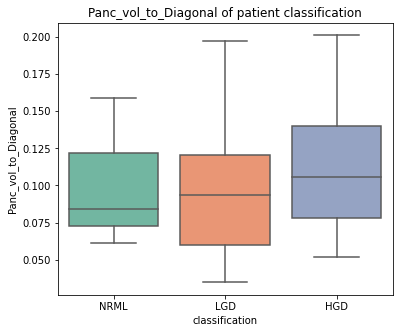

            sum_sq    df         F    PR(>F)
C(label)  0.002968   2.0  0.861057  0.428235
Residual  0.096506  56.0       NaN       NaN


In [40]:
column = "Panc_vol_to_Diagonal"
boxplot(column)

In [43]:
#3 T-tests pair-wise:
volume_0 = all_with_duct_label_df.loc[all_with_duct_label_df['label'] == 0, column].to_numpy() #NRML 
volume_1 = all_with_duct_label_df.loc[all_with_duct_label_df['label'] == 1, column].to_numpy() #LGD 
volume_2 = all_with_duct_label_df.loc[all_with_duct_label_df['label'] == 2, column].to_numpy() #HGD
print('Volume, NRML vs. LGD:') 
st.ttest_ind(a=volume_0, b=volume_1)

Volume, NRML vs. LGD:


Ttest_indResult(statistic=nan, pvalue=nan)

In [44]:
print('Volume, NRML vs. HGD:')
st.ttest_ind(a=volume_0, b=volume_2)

Volume, NRML vs. HGD:


Ttest_indResult(statistic=nan, pvalue=nan)

In [45]:
# LGD vs. HGD
print('Volume, LGD vs. HGD:') 
st.ttest_ind(a=volume_1, b=volume_2)

Volume, LGD vs. HGD:


Ttest_indResult(statistic=nan, pvalue=nan)

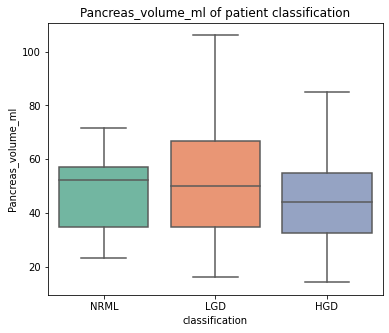

                sum_sq    df        F    PR(>F)
C(label)    616.832716   2.0  0.76141  0.469836
Residual  38480.644473  95.0      NaN       NaN


In [47]:
column = "Pancreas_volume_ml"
boxplot(column)

In [49]:
#3 T-tests pair-wise:
volume_0 = all_with_duct_label_df.loc[all_with_duct_label_df['label'] == 0, column].to_numpy() #NRML 
volume_1 = all_with_duct_label_df.loc[all_with_duct_label_df['label'] == 1, column].to_numpy() #LGD 
volume_2 = all_with_duct_label_df.loc[all_with_duct_label_df['label'] == 2, column].to_numpy() #HGD
print('Volume, NRML vs. LGD:') 
st.ttest_ind(a=volume_0, b=volume_1)

Volume, NRML vs. LGD:


Ttest_indResult(statistic=-0.4970288441054697, pvalue=0.620683049817981)

In [50]:
print('Volume, NRML vs. HGD:')
st.ttest_ind(a=volume_0, b=volume_2)

Volume, NRML vs. HGD:


Ttest_indResult(statistic=0.3530574045185046, pvalue=0.7263606032407988)

In [51]:
# LGD vs. HGD
print('Volume, LGD vs. HGD:') 
st.ttest_ind(a=volume_1, b=volume_2)

Volume, LGD vs. HGD:


Ttest_indResult(statistic=1.174087037356133, pvalue=0.24360123180332577)

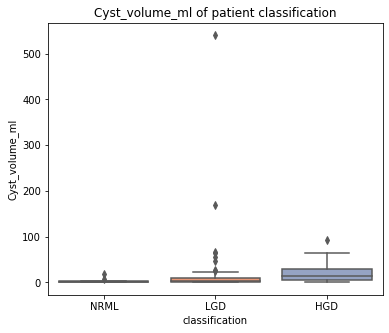

                 sum_sq    df         F    PR(>F)
C(label)    2479.170156   2.0  0.362166  0.697124
Residual  325156.639492  95.0       NaN       NaN


In [52]:
column = "Cyst_volume_ml"
boxplot(column)

In [53]:
#3 T-tests pair-wise:
volume_0 = all_with_duct_label_df.loc[all_with_duct_label_df['label'] == 0, column].to_numpy() #NRML 
volume_1 = all_with_duct_label_df.loc[all_with_duct_label_df['label'] == 1, column].to_numpy() #LGD 
volume_2 = all_with_duct_label_df.loc[all_with_duct_label_df['label'] == 2, column].to_numpy() #HGD
print('Volume, NRML vs. LGD:') 
st.ttest_ind(a=volume_0, b=volume_1)

Volume, NRML vs. LGD:


Ttest_indResult(statistic=-0.7247662837388588, pvalue=0.4709442412328365)

In [54]:
print('Volume, NRML vs. HGD:')
st.ttest_ind(a=volume_0, b=volume_2)

Volume, NRML vs. HGD:


Ttest_indResult(statistic=-2.390509718992739, pvalue=0.022880811901724883)

In [55]:
# LGD vs. HGD
print('Volume, LGD vs. HGD:') 
st.ttest_ind(a=volume_1, b=volume_2)

Volume, LGD vs. HGD:


Ttest_indResult(statistic=-0.07138671532780166, pvalue=0.9432557335876188)

In [61]:
'''
model = ols(formula='Panc_vol_to_Diagonal ~ 1 + C(label) + Age + C(Gender)+C(CP)+C(DM)', data = merged_df)
fitted1 = model.fit()
print(fitted1.summary())
aov_table = sm.stats.anova_lm(fitted1, typ=2)
print(aov_table)
'''

"\nmodel = ols(formula='Panc_vol_to_Diagonal ~ 1 + C(label) + Age + C(Gender)+C(CP)+C(DM)', data = merged_df)\nfitted1 = model.fit()\nprint(fitted1.summary())\naov_table = sm.stats.anova_lm(fitted1, typ=2)\nprint(aov_table)\n"

In [45]:
'''columns_of_interest = ['Pancreas volume (ml)', 'Cyst volume (ml)', 'Panc + Cyst volume (ml)',
                       'Cyst_1_area (mm3)', 'Cyst_1_major (mm)', 'Cyst_1_minor (mm)',
                       'Cyst_2_area (mm3)', 'Cyst_2_major (mm)', 'Cyst_2_minor (mm)',
                       'Cyst_3_area (mm3)', 'Cyst_3_major (mm)', 'Cyst_3_minor (mm)',
                       'Age', 'Gender', 'BMI', 'CP', 'DM']

# Calculate the correlation matrix
correlation_matrix = merged_df[columns_of_interest].corr()

# Display the correlation matrix
print(correlation_matrix)'''

                         Pancreas volume (ml)  Cyst volume (ml)  \
Pancreas volume (ml)                 1.000000          0.248965   
Cyst volume (ml)                     0.248965          1.000000   
Panc + Cyst volume (ml)              0.488925          0.966584   
Cyst_1_area (mm3)                    0.271299          0.998810   
Cyst_1_major (mm)                    0.082091          0.440864   
Cyst_1_minor (mm)                    0.434493          0.569131   
Cyst_2_area (mm3)                   -0.002524          0.237125   
Cyst_2_major (mm)                    0.053578          0.400992   
Cyst_2_minor (mm)                   -0.007998          0.025040   
Cyst_3_area (mm3)                   -0.028950          0.201986   
Cyst_3_major (mm)                    0.100436          0.110269   
Cyst_3_minor (mm)                    0.092344         -0.168873   
Age                                 -0.513615         -0.303659   
Gender                              -0.070306          0.15119

/tmp/ipykernel_16043/1336448874.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = merged_df[columns_of_interest].corr()


In [14]:
'''BaseException'''


segmentation_0159.nii.gz
0159 (1.3671875, 1.3671875, 4.4000015) (1.3671875, 1.3671875, 4.4)
segmentation_0172.nii
0172 (1.5625, 1.5625, 4.399994) (1.5625, 1.5625, 4.4)
segmentation_0140.nii.gz
0140 (0.68359375, 0.68359375, 6.5000076) (0.68359375, 0.68359375, 6.5)


,Center,Patient,Pancreas volume (ml),Cyst volume (ml),Panc + Cyst volume (ml),Cyst_1_area,Cyst_1_major,Cyst_1_minor,Cyst_2_area,Cyst_2_major,Cyst_2_minor,Cyst_3_area,Cyst_3_major,Cyst_3_minor
0,NYU,0020,97.764258,13.383984,111.148242,12498.046875,35.674,5.269,137.109375,13.773,0.000,290.039062,10.627,NaN
1,NYU,0168,64.943360,30.059498,95.002857,28809.460258,36.017,10.798,400.402668,9.885,NaN,97.659187,6.928,0.000
2,NYU,0133,71.207464,0.997658,72.205123,997.658434,17.907,2.193,NaN,NaN,NaN,NaN,NaN,NaN
3,NYU,0118,31.687012,8.073730,39.760742,2832.031250,135.207,6.593,4428.710938,57.216,8.854,63.476562,10.992,1.096
4,NYU,0099,45.633945,0.156013,45.789959,28.366089,3.873,0.000,7.091522,0.000,0.000,7.091522,0.000,0.000


In [19]:
''#WITH EIGENVALUES

#fig, axs = plt.subplots(1, 3, figsize=(15, 5))

df = create_df()

for eachpatientind in range(len(seg_file_paths)):
    
    pt_name = seg_file_paths[eachpatientind].split("/")[-1].split("_")[1].split(".")[0]
    if seg_file_paths[eachpatientind].split("/")[-1].split("_")[-1] == 'pass.nii': continue
    if pt_name == '0089': continue
    # Read niftii image and segmentation
    #print(pt_name)
    img_nib = nib.load(mri_file_paths[eachpatientind])
    seg_nib = nib.load(seg_file_paths[eachpatientind])
    
    #print(pt_name, img_nib.header.get_zooms(), seg_nib.header.get_zooms())
    #print(pt_name, img_nib.shape, seg_nib.shape)

    if pt_name in ['0140', '0159', '0172']:
        print(seg_file_paths[eachpatientind].split("/")[-1])
        print(pt_name, img_nib.header.get_zooms(), seg_nib.header.get_zooms())
    else:
        assert img_nib.header.get_zooms() == seg_nib.header.get_zooms()
    assert img_nib.shape == seg_nib.shape

    zx, zy, zz = img_nib.header.get_zooms()
    voxel_sizes = img_nib.header.get_zooms()

    img = img_nib.get_fdata()
    seg = seg_nib.get_fdata()

    #print('img', img.shape)
    #print('seg', seg.shape)

    cysts = (seg == 5)
    pancreas = (seg == 1)

    # Find Bboxes
    blobs = connected_component_analysis(cysts, thr=0.5)
    #print("num of blobs", len(blobs))

    # Calculate the voxel volume (assuming isotropic voxel size)
    voxel_vol_mm3 = zx * zy* zz     #voxel_volume_mm3 = 1.0  # Specify the voxel volume in your desired units

    # Calculate the volume of the segmentation mask
    cysts_volume_mm3 = np.sum(cysts != 0) * voxel_vol_mm3
    cysts_volume_ml = cysts_volume_mm3 / 1000

    pancreas_volume_mm3= np.sum(pancreas != 0) * voxel_vol_mm3
    pancreas_volume_ml= pancreas_volume_mm3 / 1000

    column_data = ['NYU', pt_name, pancreas_volume_ml, cysts_volume_ml, pancreas_volume_ml + cysts_volume_ml]


    result = largest3rs(blobs, voxel_sizes)
    # Print the result
    for i, props in enumerate(result, start=1):
        #print(f"Top {i}: Area={props[0]}, Major={props[1]}, Minor={props[2]}")
        area, major, minor = props[0]*voxel_vol_mm3, props[1], props[2]
        column_data.append(area)
        column_data.append(major)
        column_data.append(minor)

    #print(column_data)
    column_data.extend([math.nan] * (14 - len(column_data)))
    #print(column_data)

    df.loc[len(df)] = column_data

df.head()

#plt.show()
''

segmentation_0159.nii.gz
0159 (1.3671875, 1.3671875, 4.4000015) (1.3671875, 1.3671875, 4.4)
segmentation_0172.nii
0172 (1.5625, 1.5625, 4.399994) (1.5625, 1.5625, 4.4)
segmentation_0140.nii.gz
0140 (0.68359375, 0.68359375, 6.5000076) (0.68359375, 0.68359375, 6.5)


,Center,Patient,Pancreas volume (ml),Cyst volume (ml),Panc + Cyst volume (ml),Cyst_1_area,Cyst_1_major,Cyst_1_minor,Cyst_2_area,Cyst_2_major,Cyst_2_minor,Cyst_3_area,Cyst_3_major,Cyst_3_minor
0,NYU,0020,97.764258,13.383984,111.148242,12498.046875,214.045,4.940,137.109375,82.636,0.000,290.039062,63.761,NaN
1,NYU,0168,64.943360,30.059498,95.002857,28809.460258,144.073,16.872,400.402668,39.541,NaN,97.659187,27.714,0.000
2,NYU,0133,71.207464,0.997658,72.205123,997.658434,78.789,1.884,NaN,NaN,NaN,NaN,NaN,NaN
3,NYU,0118,31.687012,8.073730,39.760742,2832.031250,540.827,5.151,4428.710938,228.863,6.917,63.476562,43.969,0.856
4,NYU,0099,45.633945,0.156013,45.789959,28.366089,17.041,0.000,7.091522,0.000,0.000,7.091522,0.000,0.000


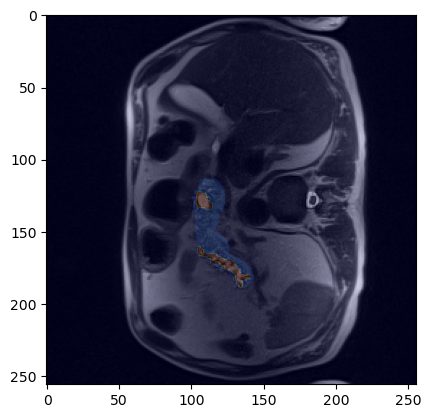

In [128]:
plt.imshow(img[:, :, 32], cmap='gray')
plt.imshow(seg[:, :, 32], cmap='jet', alpha=0.2)
plt.show()

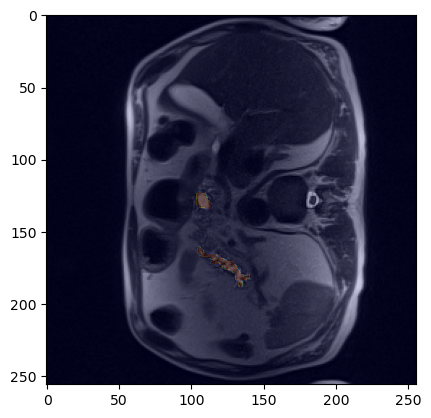

In [125]:

plt.imshow(img[:, :, 32], cmap='gray')
plt.imshow(cysts[:, :, 32], cmap='jet', alpha=0.2)
plt.show()

In [126]:
'''blobs = connected_component_analysis(cysts, thr=0.5)

i=0
for r in blobs:
    print(f"Box {i+1}", 
          "\nBounding box", r.bbox, 
          "\nArea", r.area, 
          "\nAxis major lenght", round(r.axis_major_length,3), 
          #"\nAxis minor lenght", round(r.axis_minor_length,3), 
          "\nCentroid", r.centroid,
          "\n-------------------------" )
    i += 1'''

img (256, 256, 63)
seg (256, 256, 63)
Box 1 
Bounding box (99, 98, 29, 194, 145, 46) 
Area 5148 
Axis major lenght 100.603 
Centroid (127.72183372183372, 115.11402486402487, 37.57167832167832) 
-------------------------
Box 2 
Bounding box (142, 104, 29, 143, 105, 30) 
Area 1 
Axis major lenght 0.0 
Centroid (142.0, 104.0, 29.0) 
-------------------------
Box 3 
Bounding box (146, 120, 31, 150, 124, 32) 
Area 12 
Axis major lenght 4.282 
Centroid (147.5, 121.5, 31.0) 
-------------------------


In [12]:
'''for bbox in bboxes:
    x1,y1,z1,x2,y2,z2 = bbox
    print(x1,y1,z1,x2,y2,z2)
    for z in range(z1, z2):
        slice = cysts[:,:,z].copy()
        slice = slice.astype(float)*255
        cv2.rectangle(slice, (x1, y1), (x2, y2), (255,0,0), 2)
        cv2.imwrite(join(r'C:\Users\pky0507\Desktop\ilkin\pancreas_ipmn\temporary_folder_cyst_segmentations\nyu\temp','{}.png'.format(z)), slice)'''



99 98 29 194 145 46
142 104 29 143 105 30
146 120 31 150 124 32


In [32]:
'''cysts_list = []
for slice in np.swapaxes(seg, 0, 2).tolist():
    slice_new = np.array(slice).copy().astype(float)#*255
    slice_new = np.concatenate((slice_new[:,:,None], slice_new[:,:,None], slice_new[:,:,None]), axis=2)
    #slice_new = cv2.cvtColor(slice_new, cv2.COLOR_GRAY2BGR)
    #print(slice_new.shape, slice_new.min(), slice_new.max())
    cysts_list.append(slice_new)

print(len(cysts_list))
#print(cysts_list.shape)
for bbox in bboxes:
    x1,y1,z1,x2,y2,z2 = bbox
    print(x1,y1,z1,x2,y2,z2)
    color1 = (list(np.random.choice(range(256), size=3)))  
    color =[int(color1[0]), int(color1[1]), int(color1[2])]
    for z in range(z1, z2):      
        cv2.rectangle(cysts_list[z], (x1, y1), (x2, y2), color, 2)


for i, slice in enumerate(cysts_list):
    cv2.imwrite(join(r'C:\Users\pky0507\Desktop\ilkin\pancreas_ipmn\temporary_folder_cyst_segmentations\nyu\temp','{}.png'.format(i)), slice)

for ml in axis_major_length_list:
    print(ml)
'''

63
99 98 29 194 145 46
142 104 29 143 105 30
146 120 31 150 124 32
100.60336055296284
0.0
4.281744192888377
